距离权重矩阵主要是借助距离来构建权重矩阵。

In [10]:
import numpy as np
import pysal as ps
import libpysal as lps
import geopandas as gpd

## 1.1k最近邻二元权重
需要指定最近邻居个数，默认值为2，p是距离度量的方幂次数，默认值是2，即欧几里得距离，idVariable是点变量的编号，必须包含dbf文件并且与shape文件一致；radius：地球半径，在使用经纬度计算时起作用

In [2]:
wk1 = ps.knnW_from_shapefile(ps.examples.get_path('baltim.shp') , k=4 , idVariable='STATION')
wk1.id_order[:3]

[1, 2, 3]

In [6]:
wk1.weights[1]

[1.0, 1.0, 1.0, 1.0]

In [7]:
wk1.neighbors[1]

[96, 16, 90, 133]

In [8]:
# 进行行标准化
wk1.transform = 'r'
wk1.weights[1]

[0.25, 0.25, 0.25, 0.25]

## 1.2距离范围二元权重
得到距离权重需要两步：

1. 计算范围下届，确保每个点都有邻居
2. 利用下届值作为函数参数，生成权重矩阵

In [12]:
path = ps.examples.get_path('baltim.shp')
df = gpd.read_file(path)
df.head(2)

,STATION,PRICE,NROOM,DWELL,NBATH,PATIO,FIREPL,AC,BMENT,NSTOR,GAR,AGE,CITCOU,LOTSZ,SQFT,X,Y,geometry
0,1,47.0,4.0,0.0,1.0,0.0,0.0,0.0,2.0,3.0,0.0,148.0,0.0,5.70,11.25,907.0,534.0,POINT (907.000 534.000)
1,2,113.0,7.0,1.0,2.5,1.0,1.0,1.0,2.0,2.0,2.0,9.0,1.0,279.51,28.92,922.0,574.0,POINT (922.000 574.000)


<AxesSubplot:>

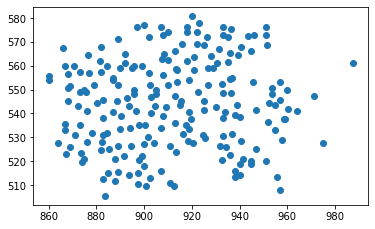

In [13]:
df.plot()

In [9]:
mdist = ps.min_threshold_dist_from_shapefile(ps.examples.get_path('baltim.shp'))
print(mdist)

21.319005605327842


上述得到的参数就是每个点与其最近邻邻居距离的最大值，即21.3。

In [17]:
wk2 = ps.threshold_binaryW_from_shapefile(path , mdist-0.0001)
wk2.islands

[101]

In [18]:
wk2 = ps.threshold_binaryW_from_shapefile(path , mdist)
wk2.islands

[]

In [20]:
wk2.weights[3]

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

需要将权重矩阵转化为r型，即行标准化，在此不在操作。

## 1.3核权重对象

核权重对象是利用核函数来生成的，其实和距离权重矩阵是有点像的。
公式为：$$w_{ij}=K(z_{ij})$$，其中$z_{ij}$为：$$z_{ij}=d_{ij}/h_i$$，其中hi是带宽,K()是核函数，如果两个点间的距离大于带宽的话，则这两点间的权重就是0了，下面列举几种常见的核函数：三角核函数：$$K(z)=(1-|z|,|z|<1$$。均匀核函数为$$K(z)=1/2,|z|<1$$
核函数的带宽有可变带宽和固定带宽两种，可变带宽一般来说更好一点，固定带宽当点分布很不均匀的时候往往就会出现问题了。

In [21]:
len(df)

211

In [29]:
# spreg的HAC估计需要最少的邻居数量大于等于样本数的三次方根，样本数是211，三次方根是5.x，因此每个样本的邻居数量需要大于等于6.
# 默认是使用三角形核函数进行计算
wk3= ps.adaptive_kernelW_from_shapefile(path ,function='triangular', k=6)
wk3.weights[2]

[1.0,
 0.6512571186428303,
 0.5573422238830965,
 0.4015787132074117,
 0.4015787132074117,
 0.08743761653449622,
 9.99999900663795e-08]

In [30]:
# 转化为numpy的权重矩阵进行观察
wk3.full()

(array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 4.01578713e-01, 1.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.00000000e+00, 2.39883126e-01, 2.54644082e-01],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         3.67544531e-01, 1.00000000e+00, 2.05790264e-01],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         2.19131269e-01, 9.99999901e-08, 1.00000000e+00]]),
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,

In [31]:
wk3.full()[0].shape

(211, 211)

In [33]:
wk3.neighbors

{0: [0, 95, 15, 89, 132, 177, 90],
 1: [1, 4, 3, 6, 184, 14, 179],
 2: [2, 3, 6, 1, 4, 184, 14],
 3: [3, 1, 2, 6, 4, 184, 14],
 4: [4, 6, 1, 10, 3, 14, 2],
 5: [5, 9, 69, 7, 11, 13, 47],
 6: [6, 4, 1, 2, 3, 10, 14],
 7: [7, 11, 13, 69, 5, 9, 6],
 8: [8, 194, 75, 210, 67, 12, 10],
 9: [9, 5, 69, 47, 7, 11, 57],
 10: [10, 12, 4, 14, 6, 8, 194],
 11: [11, 13, 7, 69, 66, 12, 10],
 12: [12, 10, 64, 66, 68, 8, 67],
 13: [13, 11, 7, 10, 4, 6, 69],
 14: [14, 179, 1, 184, 194, 10, 4],
 15: [15, 17, 178, 95, 0, 16, 73],
 16: [16, 17, 178, 73, 134, 138, 133],
 17: [17, 16, 73, 178, 15, 72, 134],
 18: [18, 20, 19, 21, 24, 23, 199],
 19: [19, 18, 24, 199, 23, 20, 190],
 20: [20, 18, 202, 19, 24, 199, 203],
 21: [21, 203, 71, 204, 22, 18, 205],
 22: [22, 71, 74, 21, 23, 72, 18],
 23: [23, 74, 19, 18, 191, 22, 190],
 24: [24, 199, 19, 20, 18, 186, 190],
 25: [25, 36, 37, 26, 45, 29, 34],
 26: [26, 29, 38, 34, 37, 33, 32],
 27: [27, 31, 34, 38, 32, 33, 152],
 28: [28, 41, 31, 32, 30, 35, 85],
 29: [29

In [32]:
wk3.weights

{0: [1.0,
  0.29289328952412363,
  0.12294206839876398,
  0.0880073449393135,
  0.056907799290817906,
  0.007237830111578081,
  9.99999900663795e-08],
 1: [1.0,
  0.3615305562728467,
  0.34188076119589894,
  0.28616946113480424,
  0.21397565474242586,
  0.20191319534105834,
  9.99999900663795e-08],
 2: [1.0,
  0.6512571186428303,
  0.5573422238830965,
  0.4015787132074117,
  0.4015787132074117,
  0.08743761653449622,
  9.99999900663795e-08],
 3: [1.0,
  0.544679199127337,
  0.5314787611863058,
  0.40530809165277093,
  0.2928932895241235,
  0.23291818137604625,
  9.99999899553572e-08],
 4: [1.0,
  0.725278899574732,
  0.45055779914946403,
  0.2602907991062915,
  0.12046333166637146,
  0.12046333166637146,
  9.99999900663795e-08],
 5: [1.0,
  0.7476227926751864,
  0.5702171026512237,
  0.43566740845015883,
  0.28616946113480424,
  0.16677291386436277,
  9.99999900663795e-08],
 6: [1.0,
  0.7519305556285275,
  0.445299859244785,
  0.33205257922266795,
  0.33205257922266795,
  0.0970135924